# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv', index_col=0)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


In [4]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Time         object
#CigSales     int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
# Don't need to because I set it as index

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [9]:
cigData.columns=['Month', '#CigSales']

Call a head() to check this has worked. 

In [10]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [11]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [12]:
cigData.set_index('Month', inplace=True)

In [33]:
cigData.index.freq='MS'

In [13]:
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [14]:
# Scale the data per FrankF's suggestion
cigData['#CigSales'] = (cigData['#CigSales'] - 1_000_000) * 100_000

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [15]:
y=cigData['#CigSales']

Check the type of our new variable. 

In [16]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [17]:
cigData.describe()

,#CigSales
count,1.440000e+02
mean,2.802986e+07
std,1.199663e+07
min,1.040000e+07
25%,1.800000e+07
50%,2.655000e+07
75%,3.605000e+07
max,6.220000e+07


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

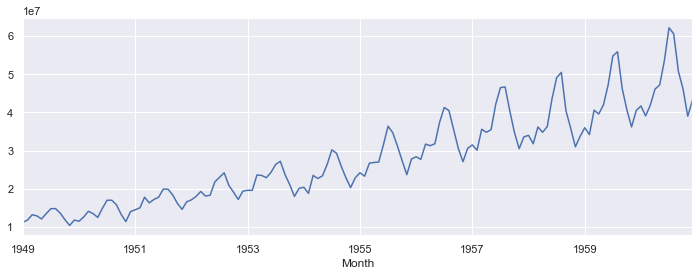

In [18]:
y.plot(figsize=(12,4));

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-multiplicative because of exponential trend and growing effect of seasonality------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the original data, the trend, the seasonality, and the residuals 
decomp = seasonal_decompose(y, model='mul')

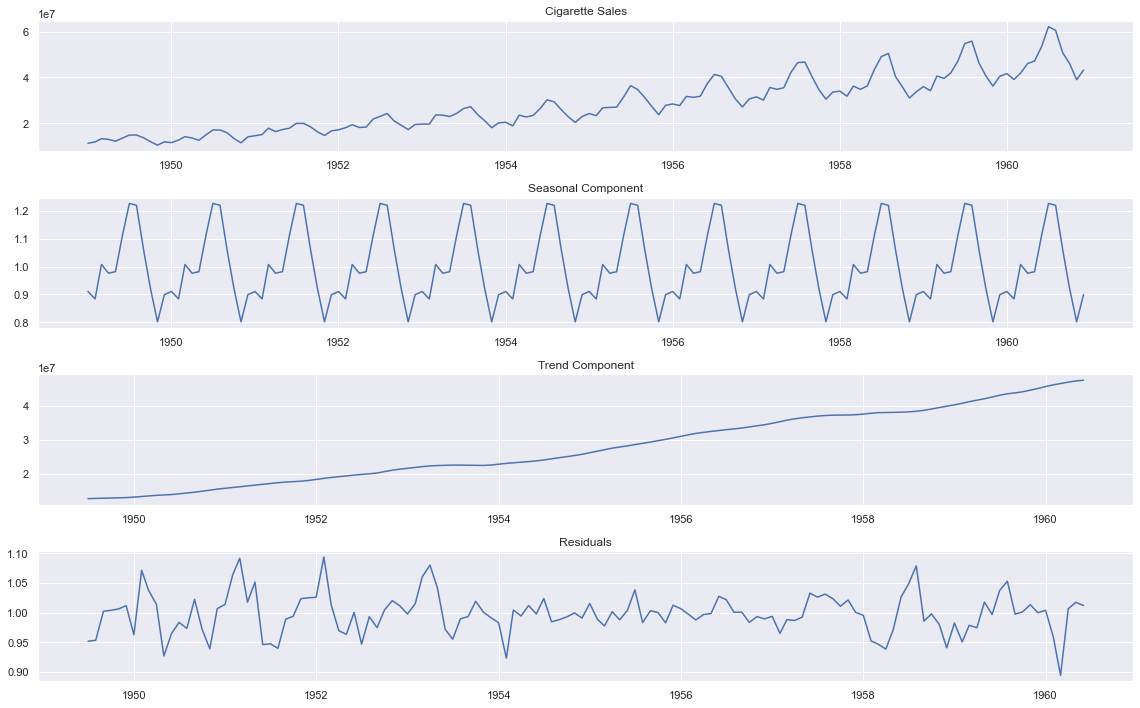

In [20]:
plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(y, label = '#CigSales')
plt.title('Cigarette Sales')
plt.subplot(412)
plt.plot(decomp.seasonal, label = 'Seasonal')
plt.title('Seasonal Component')
plt.subplot(413)
plt.plot(decomp.trend, label = 'Trend')
plt.title('Trend Component')
plt.subplot(414)
plt.plot(decomp.resid, label = 'Residuals')
plt.title('Residuals')
plt.tight_layout();

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [21]:
from statsmodels.tsa.stattools import kpss
res = kpss(y, nlags='auto')
print('p-value is {}', res[1])

p-value is {} 0.01


/Users/ruthcsmith/opt/anaconda3/envs/TestEnv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Null hypothesis for kpss is that the data is stationary.  Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

In [22]:
# Let's also run an Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
res= adfuller(y)
print('p-value is {}', res[1])

p-value is {} 0.991880243437663


The null hypothesis for ADfuller is that the data is non-stationary, so with this p-value we cannot reject the null hypothesis and we also conclude that the data is non-stationary.  

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

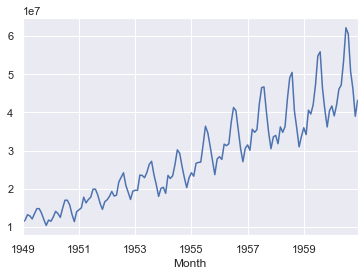

In [23]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often-used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [24]:
log_y = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

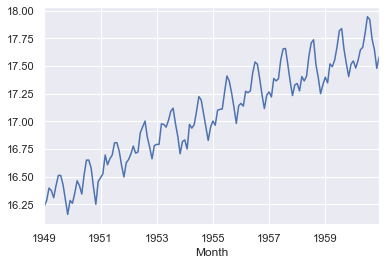

In [25]:
log_y.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [26]:
log_y_diff = log_y.diff()
log_y_diff.dropna(inplace=True)
res = kpss(log_y_diff, nlags='auto')
print('pvalue is {}'.format(res[1]))

pvalue is 0.1


/Users/ruthcsmith/opt/anaconda3/envs/TestEnv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [27]:
res= adfuller(log_y_diff)
print('pvalue is {}'.format(res[1]))

pvalue is 0.07112054815086125


Interesting, ADFuller returns p-value of just over .05, so according to that test our data is not quite stationary.  However we'll go on for now.  

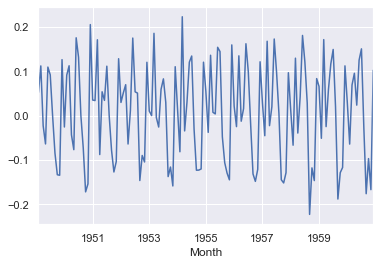

In [28]:
log_y_diff.plot();

In [29]:
#Try a second order differencing
log_y_diff_diff = log_y_diff.diff()
log_y_diff_diff.dropna(inplace=True)
res= adfuller(log_y_diff)
print('pvalue is {}'.format(res[1]))

pvalue is 0.07112054815086125


Hmm...that's not any better

### 3d. The SARIMA model 
(note I am using SARIMA instead of ARIMA as notebook suggests since data is obviously seasonal.  I am also using pmdarima.auto_arima to determine p,d,q,P,D,Q values)

In [34]:
from pmdarima import auto_arima # for determining ARIMA orders

auto_arima(cigData['#CigSales'],seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -2017.133
Date:                            Thu, 07 Jan 2021   AIC                           4040.265
Time:                                    13:47:23   BIC                           4048.891
Sample:                                         0   HQIC                          4043.770
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2150      0.056     -3.821      0.000      -0.325      -0.105
ar.S.L12      -0.1069      0.089     -1.205      0.228      -0.281       0.067
sigma2      1.379e+12   1.87e-14   7.37e+25      0.000    1.38e+12    1.38e+12
===================================================================================
Ljung-Box (Q):                       53.79   Jarque-Bera (JB):                12.23
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+41. Standard errors may be unstable.
"""

In [35]:
stepwise_fit = auto_arima(cigData['#CigSales'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=4051.218, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4048.500, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4040.265, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4040.544, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4040.595, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4042.094, Time=0.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=4042.183, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4040.465, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=4048.175, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4042.215, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4042.218, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4040.314, Time=0.09 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(1,1,0)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -2017.133
Date:                            Thu, 07 Jan 2021   AIC                           4040.265
Time:                                    13:49:01   BIC                           4048.891
Sample:                                         0   HQIC                          4043.770
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2150      0.056     -3.821      0.000      -0.325      -0.105
ar.S.L12      -0.1069      0.089     -1.205      0.228      -0.281       0.067
sigma2      1.379e+12   1.87e-14   7.37e+25      0.000    1.38e+12    1.38e+12
===================================================================================
Ljung-Box (Q):                       53.79   Jarque-Bera (JB):                12.23
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+41. Standard errors may be unstable.
"""

### Train/Test Split

In [37]:
cigData.shape

(144, 1)

In [38]:
# Let's forecast 1 year into the future, so we'll set aside the last year as test data
Train = cigData['#CigSales'][:132]
Test = cigData['#CigSales'][132:]

### Train SARIMA model

In [40]:
# Train our SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(Train,order=(1,1,0),seasonal_order=(1,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1818.445
Date:                            Thu, 07 Jan 2021   AIC                           3642.890
Time:                                    13:54:28   BIC                           3651.227
Sample:                                01-01-1949   HQIC                          3646.275
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1520      0.066     -2.291      0.022      -0.282      -0.022
ar.S.L12      -0.0738      0.081     -0.905      0.365      -0.233       0.086
sigma2      1.096e+12   8.32e-15   1.32e+26      0.000     1.1e+12     1.1e+12
===================================================================================
Ljung-Box (Q):                       43.16   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.34   Prob(JB):                         0.65
Heteroskedasticity (H):               1.47   Skew:                            -0.05
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+41. Standard errors may be unstable.
"""

### Evalute our model


In [41]:
# Obtain predicted values for range of test data
start=len(Train)
end=len(Train)+len(Test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(1,1,0,12) Predictions')

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(Test, predictions)
mse = mean_squared_error(Test, predictions)
rmse = np.sqrt(mse)
print('MAE: {}'.format(mae))
print('MSE: {}'.format(mse))
print('RMSE: {}'.format(rmse))

MAE: 1711093.2479399492
MSE: 4923769992777.511
RMSE: 2218956.96055095


Our MAE and RMSE are less than our standard deviation which is pretty good.  

### Train model on all the data

In [46]:
model = SARIMAX(cigData['#CigSales'],order=(1,1,0),seasonal_order=(1,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -2017.133
Date:                            Thu, 07 Jan 2021   AIC                           4040.265
Time:                                    14:04:10   BIC                           4048.891
Sample:                                01-01-1949   HQIC                          4043.770
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2150      0.056     -3.821      0.000      -0.325      -0.105
ar.S.L12      -0.1069      0.089     -1.205      0.228      -0.281       0.067
sigma2      1.379e+12   1.87e-14   7.37e+25      0.000    1.38e+12    1.38e+12
===================================================================================
Ljung-Box (Q):                       53.79   Jarque-Bera (JB):                12.23
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+41. Standard errors may be unstable.
"""

### Forecast

In [50]:
forecast = results.predict(0,len(cigData)+11,typ='levels').rename('SARIMA(1,1,0)(1,1,0,12) Forecast')

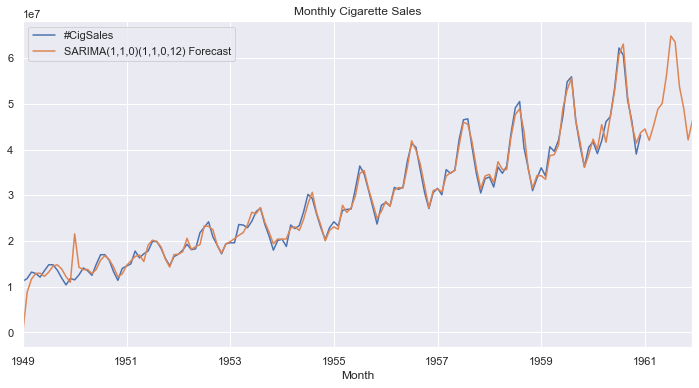

In [51]:
# Plot predictions against known values
title = 'Monthly Cigarette Sales'

ax = cigData['#CigSales'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

## 4. Evaluating and Concluding

Our SARIMA model tracked our data nicely without overfitting.  We can see that it tracks the test data quite well, and the predicted values look to follow the same trends as the original data.  